## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))


In [2]:
import sktime
sktime.__version__

'0.11.0'

# Using LinearRegression from sklearn

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import adfuller

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

<AxesSubplot:xlabel='Month'>

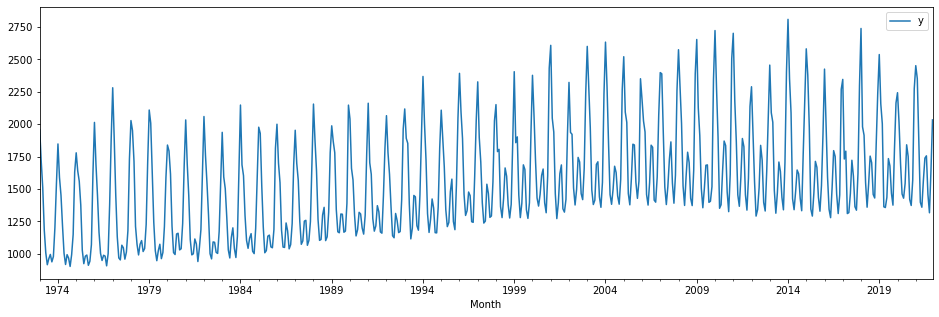

In [110]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['y']
df.plot()

In [118]:
df_diff = df.diff(12).dropna()
"Stationary" if adfuller(df_diff)[1] < 0.05 else "Non-Stationary"

'Stationary'

<AxesSubplot:xlabel='Month'>

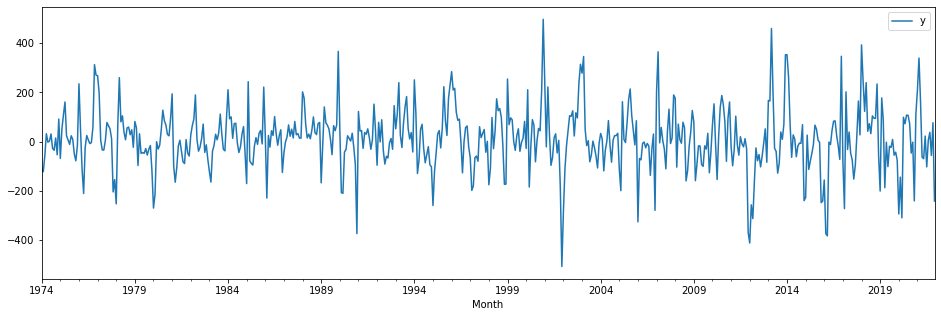

In [119]:
df_diff.plot()

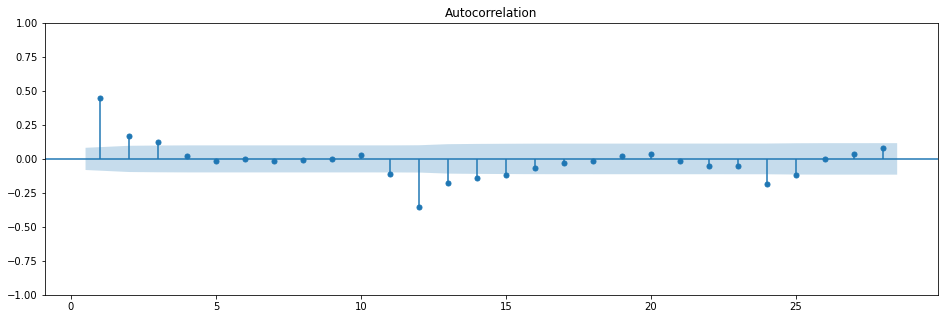

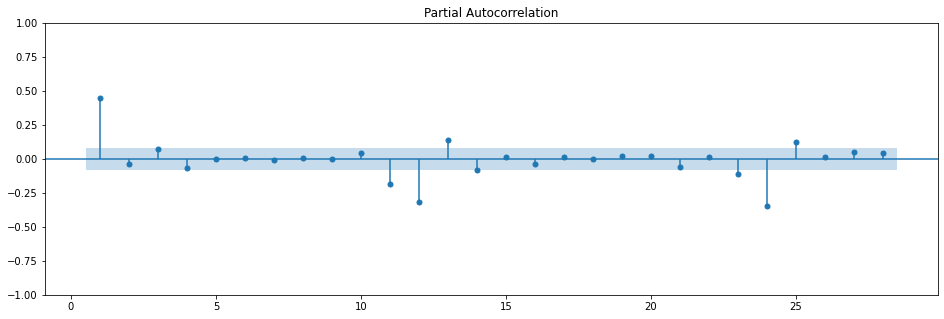

In [122]:
plot_acf(df_diff, zero=False);plt.show()
plot_pacf(df_diff, zero=False); plt.show()

In [108]:
lags = 12
for i in range(1, lags+1):
    df_diff[f'y_t-{i}'] = df_diff['y'].shift(i)
    
df_diff.dropna(inplace=True)
df_diff.head()

,y,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,y_t-6,y_t-7,y_t-8,y_t-9,y_t-10,y_t-11,y_t-12
Month,,,,,,,,,,,,,
1974-02-01,-257.482,308.362,336.463,223.943,41.079,-57.176,32.387,46.923,-91.377,-177.095,-326.658,-202.064,-245.498
1974-03-01,-138.375,-257.482,308.362,336.463,223.943,41.079,-57.176,32.387,46.923,-91.377,-177.095,-326.658,-202.064
1974-04-01,-235.845,-138.375,-257.482,308.362,336.463,223.943,41.079,-57.176,32.387,46.923,-91.377,-177.095,-326.658
1974-05-01,-211.407,-235.845,-138.375,-257.482,308.362,336.463,223.943,41.079,-57.176,32.387,46.923,-91.377,-177.095
1974-06-01,-86.986,-211.407,-235.845,-138.375,-257.482,308.362,336.463,223.943,41.079,-57.176,32.387,46.923,-91.377


In [101]:
train_lr = df_diff[:-24]
test_lr = df_diff[-24:]

x_train, y_train = train_lr.drop(columns=['y']), train_lr['y']
x_test, y_test = test_lr.drop(columns=['y']), test_lr['y']

In [102]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

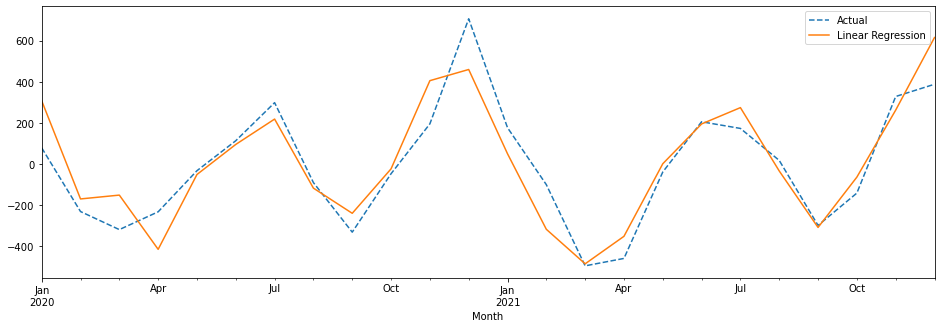

In [103]:
ax = y_test.plot(style='--')
pd.DataFrame(lr.predict(x_test), index=x_test.index).plot(ax=ax)
plt.legend(['Actual', 'Linear Regression'])

# Forecasting with sktime

Loading required modules

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction
import warnings

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

Loading the dataset and inspecting the data

In [26]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

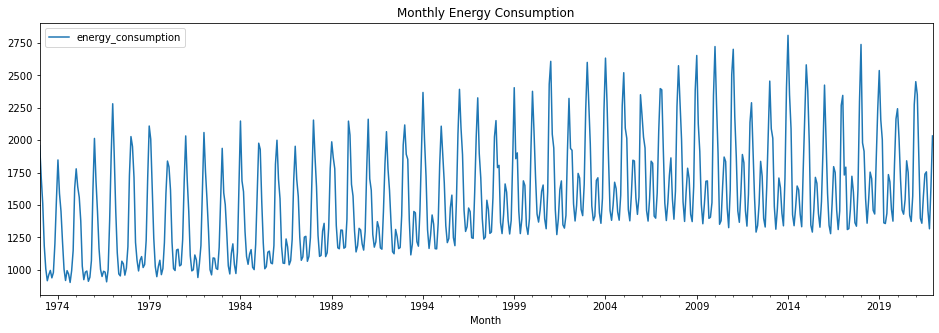

In [27]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [28]:
df.head()

,energy_consumption
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326


In [29]:
df.tail()

,energy_consumption
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [30]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [31]:
df.shape

(588, 1)

**Different ways to split your time series**


In [32]:
# using sklearn
from sklearn.model_selection import train_test_split
train, teset = train_test_split(df, test_size=24, shuffle=False)

# using sktime 
train, test = temporal_train_test_split(df, test_size=24)

# pandas slicing
size = 24
train, test = df.iloc[:-size], df.iloc[-size:]

train.columns = ['train']
test.columns = ['test']

In [33]:
test

,test
Month,
2020-01-01,2242.462
2020-02-01,2011.541
2020-03-01,1692.834
2020-04-01,1460.650
2020-05-01,1428.359
2020-06-01,1541.875
2020-07-01,1840.435
2020-08-01,1750.274
2020-09-01,1419.171


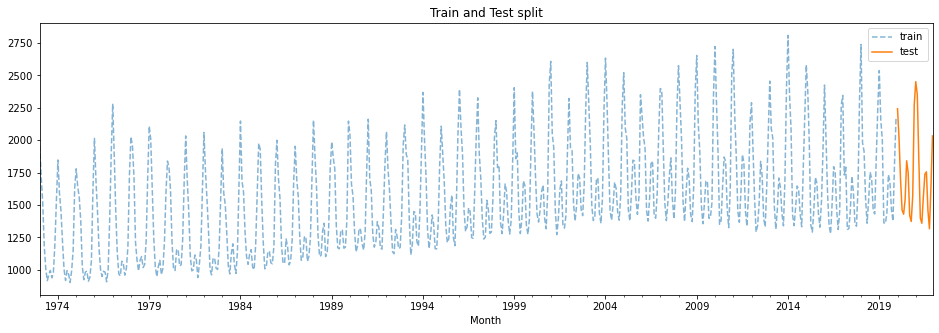

In [34]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [35]:
test.shape

(24, 1)

In [36]:
test.tail()

,test
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [37]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [38]:
adfuller(df)

(-1.449733113243752,
 0.5582151234544165,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

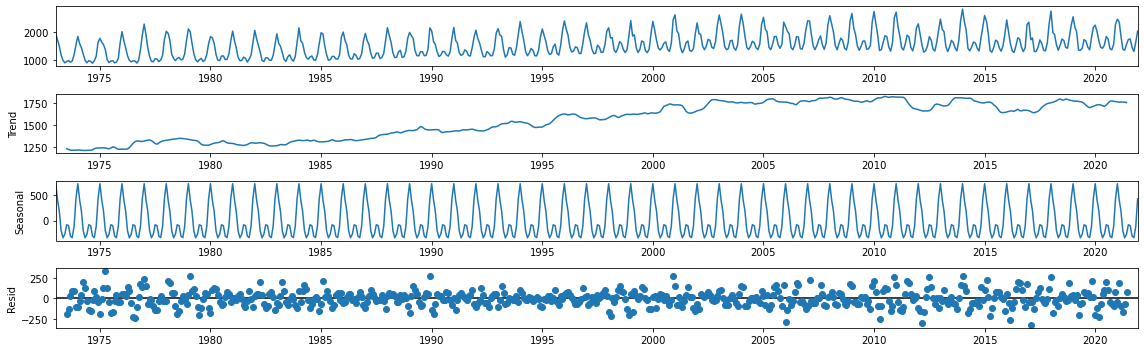

In [39]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [40]:
test.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [41]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [42]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [43]:
test.shape

(24, 7)

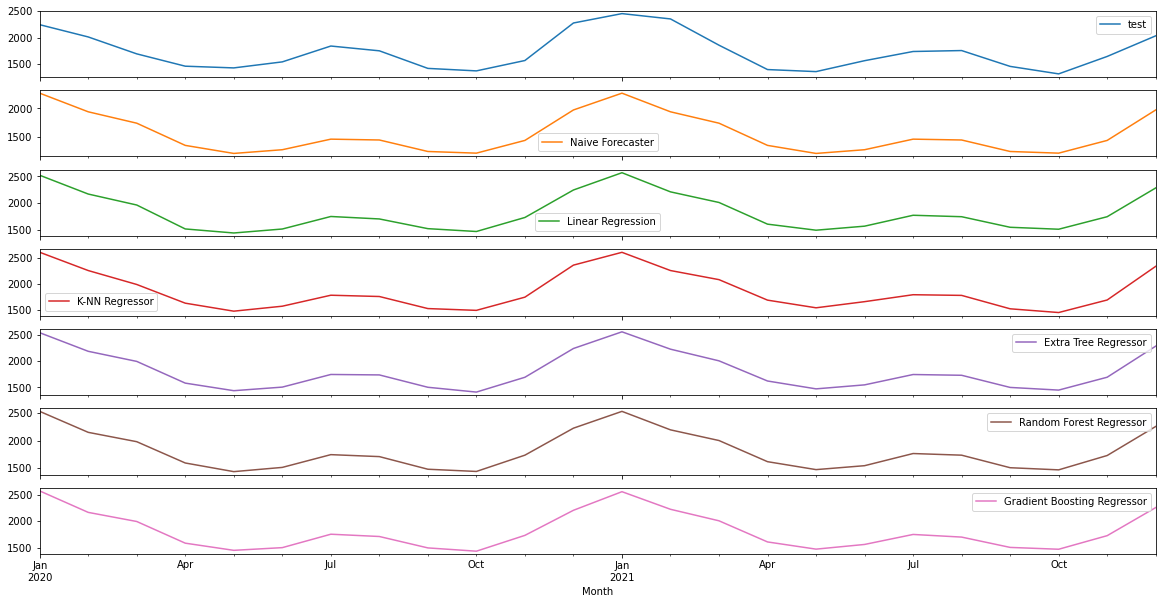

In [44]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

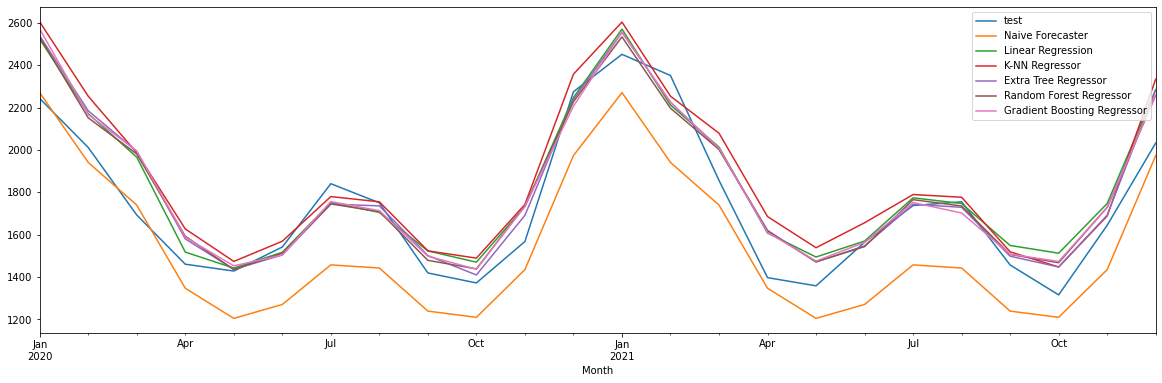

In [45]:
test.plot(subplots=False, figsize=(20, 6))

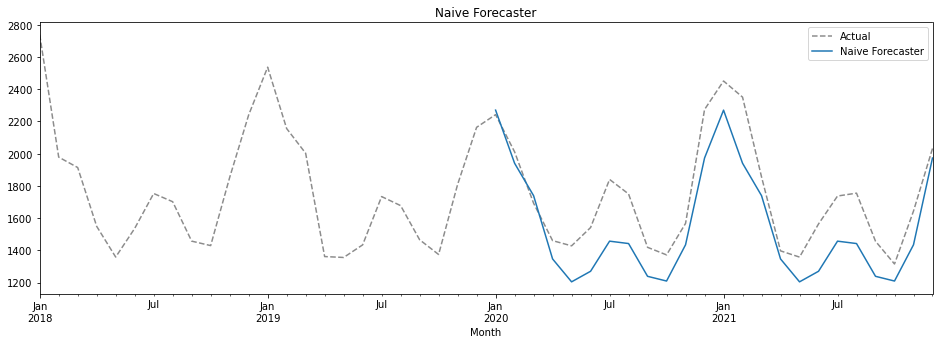

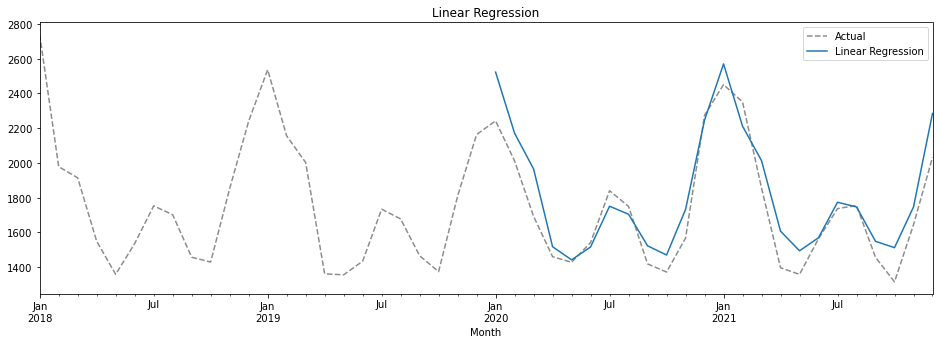

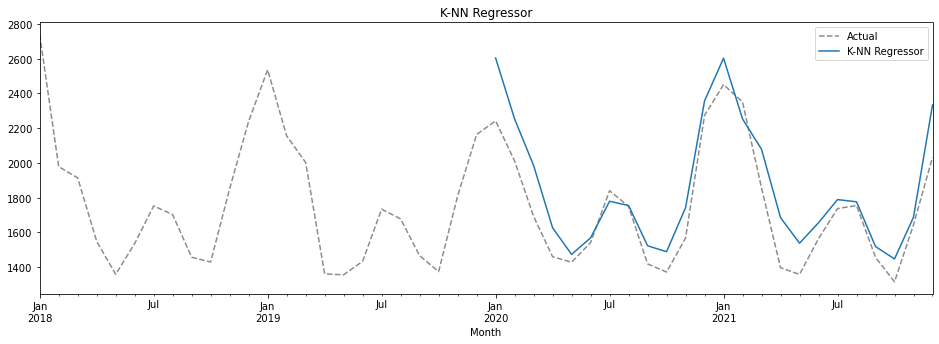

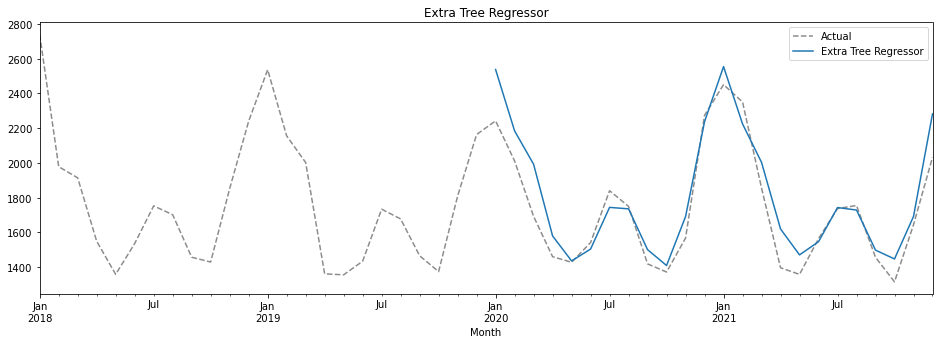

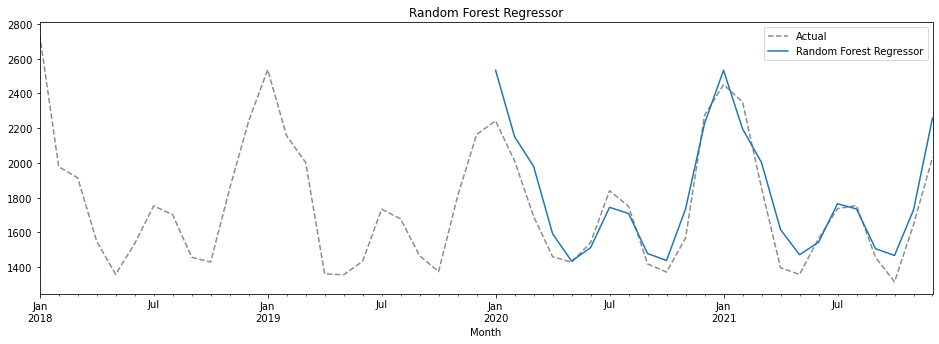

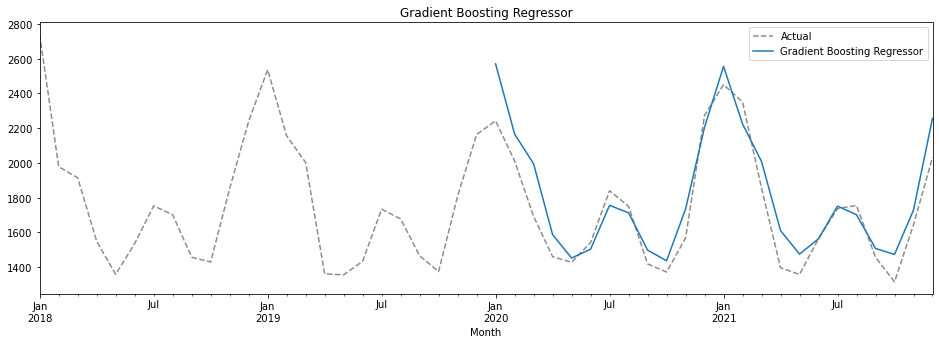

In [46]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [47]:
def evaluate(df, sort_by='sMAPE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['test']
    y_predicted = df.drop(columns=['test'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
    return evals.T.sort_values(by=sort_by)
    

In [48]:
evaluate(test)

,sMAPE,MAPE,RMSE
Extra Tree Regressor,0.058853,0.061459,137.371526
Random Forest Regressor,0.061911,0.064536,137.417509
Gradient Boosting Regressor,0.064279,0.067125,142.967258
Linear Regression,0.065325,0.068308,142.176939
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


In [49]:
evaluate(test, sort_by='RMSE')

,sMAPE,MAPE,RMSE
Extra Tree Regressor,0.058853,0.061459,137.371526
Random Forest Regressor,0.061911,0.064536,137.417509
Linear Regression,0.065325,0.068308,142.176939
Gradient Boosting Regressor,0.064279,0.067125,142.967258
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


## There is more

In [28]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [29]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  564
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3338.554
Date:                                 Fri, 08 Apr 2022   AIC                           6691.108
Time:                                         03:27:28   BIC                           6721.441
Sample:                                              0   HQIC                          6702.949
                                                 - 564                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.006      0.106      0.916      -0.011       0.012
ar.L1          0.4767      0.034     14.071      0.000       0.410       0.543
ma.L1         -0.9748      0.010   -102.212      0.000      -0.993      -0.956
ar.S.L12       0.9978      0.002    612.650      0.000       0.995       1.001
ma.S.L12      -0.7217      0.028    -25.434      0.000      -0.777      -0.666
ma.S.L24      -0.0871      0.012     -7.308      0.000      -0.110      -0.064
sigma2      7804.8584    340.564     22.917      0.000    7137.366    8472.351
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                97.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test['ARIMA'] = arima.predict(n)

In [31]:
test.shape

(24, 8)

In [32]:
test.head()

,test,Naive Forecaster,Linear Regression,K-NN Regressor,Extra Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor,ARIMA
Month,,,,,,,,
2020-01-01,2242.462,2270.323702,2522.814708,2604.277175,2528.933594,2536.450796,2570.473160,2506.947375
2020-02-01,2011.541,1940.863681,2171.116655,2253.460503,2178.930967,2151.040212,2166.817111,2084.300249
2020-03-01,1692.834,1739.600298,1965.760283,1985.997768,1977.476754,1952.271006,1995.332132,1900.006095
2020-04-01,1460.650,1347.089489,1517.825403,1627.154399,1594.253255,1584.834951,1587.730558,1407.773645
2020-05-01,1428.359,1204.958617,1442.385026,1473.659183,1433.401763,1442.829907,1452.865700,1347.337206


In [33]:
evaluate(test)

,sMAPE,MAPE,RMSE
ARIMA,0.042925,0.043336,108.738816
Extra Tree Regressor,0.061623,0.064157,135.904756
Random Forest Regressor,0.061705,0.064394,138.827577
Gradient Boosting Regressor,0.064279,0.067125,142.967258
Linear Regression,0.065325,0.068308,142.176939
K-NN Regressor,0.076512,0.080899,170.178191
Naive Forecaster,0.121355,0.112677,219.987776


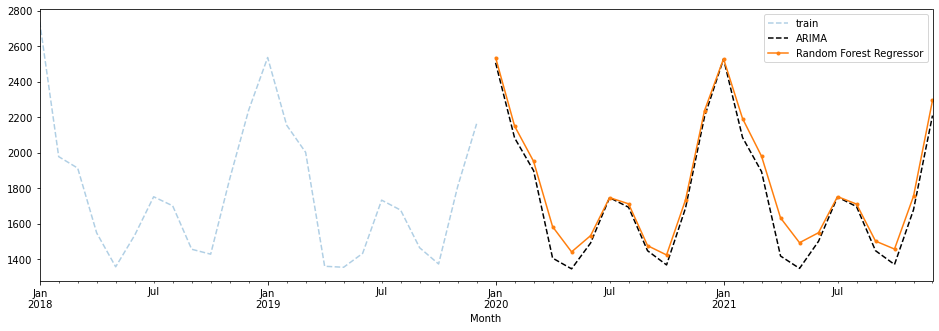

In [34]:
ax = train.loc['2018':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k--')
test['Random Forest Regressor'].plot(ax=ax, style='.-')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend()

Bontempi, Gianluca, Souhaib Ben Taieb, and Yann-Aël Le Borgne. “Machine Learning Strategies for Time Series Forecasting.” In Business Intelligence, edited by Marie-Aude Aufaure and Esteban Zimányi, 138:62–77. Lecture Notes in Business Information Processing. Berlin, Heidelberg: Springer Berlin Heidelberg, 2013. https://doi.org/10.1007/978-3-642-36318-4_3.


## Manual

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Optimizing a Machine Learning model with Hyperparameter Tuning

In [18]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [31]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

In [32]:
train, test = temporal_train_test_split(df, test_size=24)
train.columns = ['train']
test.columns = ['test']
train.shape

(564, 1)

In [33]:
test.shape

(24, 1)

In [34]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                RandomForestRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [35]:
forecaster.fit(train.values)
test['RandomForestRegressor'] = forecaster.predict(fh)

In [36]:
test.head()

,test,RandomForestRegressor
Month,,
2020-01-01,2242.462,2567.523434
2020-02-01,2011.541,2198.274815
2020-03-01,1692.834,1962.437646
2020-04-01,1460.650,1513.020806
2020-05-01,1428.359,1375.816806


In [37]:
evaluate(test)

,sMAPE,MAPE,RMSE
RandomForestRegressor,0.062807,0.065323,144.288861


In [38]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__bootstrap': True,
 'forecast__estimator__ccp_alpha': 0.0,
 'forecast__estimator__criterion': 'squared_error',
 'forecast__estimator__max_depth': None,
 'forecast__estima

In [39]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'detrend__forecaster', 'forecast__estimator__bootstrap', 'forecast__estimator__ccp_alpha', 'forecast__estimator__criterion', 'forecast__estimator__max_depth', 'forecast__estimator__max_features', 'forecast__estimator__max_leaf_nodes', 'forecast__estimator__max_samples', 'forecast__estimator__min_impurity_decrease', 'forecast__estimator__min_samples_leaf', 'forecast__estimator__min_samples_split', 'forecast__estimator__min_weight_fraction_leaf', 'forecast__estimator__n_estimators', 'forecast__estimator__n_jobs', 'forecast__estimator__oob_score', 'forecast__estimator__random_state', 'forecast__estimator__verbose', 'forecast__estimator__warm_start', 'forecast__estimator', 'forecast__window_length'])

In [223]:
# large grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 300, 500, 1000],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__max_depth": [None] + [int(x) for x in np.linspace(2, 20, num = 10)],
    "forecast__estimator__min_samples_split": [2, 5, 7],
    "forecast__estimator__min_samples_leaf": [1, 2, 4],
    "forecast__estimator__bootstrap": [True, False],
    "forecast__window_length": [10, 12, 15],
    "forecast__estimator__ccp_alpha": [0.0, 0.005, 0.01]
}

In [40]:
#smaller grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 500],
    "forecast__estimator__max_depth": [None, 2, 4],
    "forecast__estimator__min_samples_split": [2, 3, 5],
    "forecast__window_length": [10, 12, 15],
}


cv = SlidingWindowSplitter(window_length=int(len(df) * 0.90), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv, 
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [41]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529)

In [203]:
grid_csv.fit(df.values)

Fitting 36 folds for each of 54 candidates, totalling 1944 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529),
                        forecaster=TransformedTargetForecaster(steps=[('deseasonalize',
                                                                       Deseasonalizer(model='multiplicative',
                                                                                      sp=12)),
                                                                      ('detrend',
                                                                       Detrender()),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                         

In [211]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=12)),
                                   ('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                                                         min_samples_split=5,
                                                                                                         n_estimators=500),
                                                                         window_length=12))])

In [212]:
grid_csv.best_params_

{'forecast__estimator__max_depth': 4,
 'forecast__estimator__min_samples_split': 5,
 'forecast__estimator__n_estimators': 500,
 'forecast__window_length': 12}

In [227]:
grid_csv.cv_results_

In [214]:
test['RandomForestRegressor_optim'] = grid_csv.predict(fh)

In [215]:
evaluate(test)

,sMAPE,MAPE,RMSE
RandomForestRegressor_optim,0.052736,0.054957,128.603376
RandomForestRegressor,0.061285,0.063601,137.970780


In [216]:
model = grid_csv.best_forecaster_

In [217]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender()),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                        min_samples_split=5,
                                                                        n_estimators=500),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                      min_samples_split=5,
                                                                      n_estimators=500),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': None,
 'forecast__estimator__bootst

# Multivariate Forecasting and Ensemble Learning with sktime

In [4]:
from sktime.forecasting.all import (MultiplexForecaster,
                                    EnsembleForecaster,
                                   ForecastingGridSearchCV,
                                    SlidingWindowSplitter,
                                   MeanAbsolutePercentageError)
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [5]:
load_macroeconomic().shape

(203, 12)

In [6]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [7]:
econ_df.shape

(203, 5)

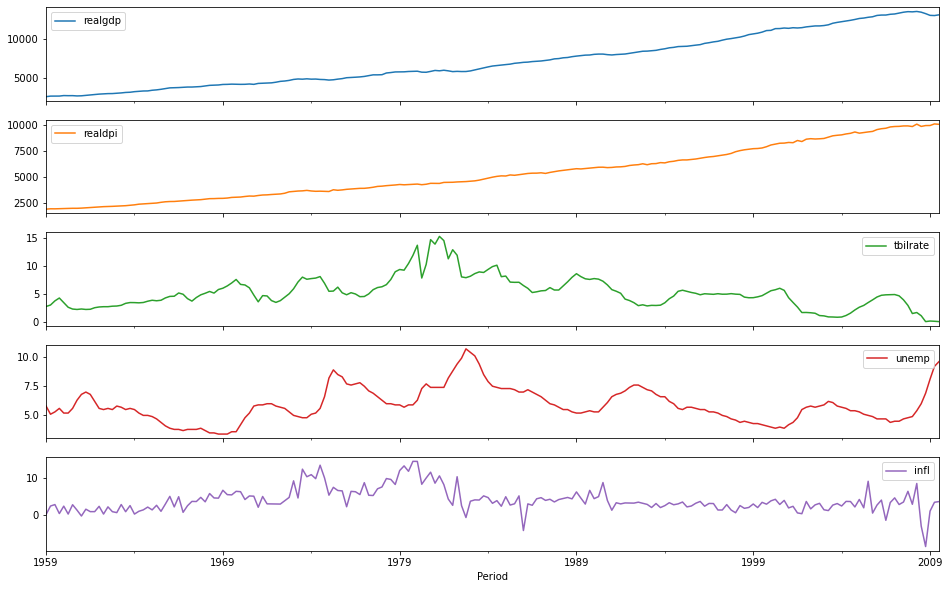

In [8]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [9]:
econ_df.head()

,realgdp,realdpi,tbilrate,unemp,infl
Period,,,,,
1959Q1,2710.349,1886.9,2.82,5.8,0.00
1959Q2,2778.801,1919.7,3.08,5.1,2.34
1959Q3,2775.488,1916.4,3.82,5.3,2.74
1959Q4,2785.204,1931.3,4.33,5.6,0.27
1960Q1,2847.699,1955.5,3.50,5.2,2.31


In [10]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [29]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [12]:
test_size = 12
y_train, y_test = temporal_train_test_split(y, test_size=test_size)
exog_train, exog_test = temporal_train_test_split(exog, test_size=test_size)

In [13]:
regressors = [
        ("LinearRegression", make_reduction(LinearRegression(), strategy='recursive')),
        ("RandomForest", make_reduction(RandomForestRegressor(), strategy='recursive')),
        ("SupportVectorRegressor", make_reduction(SVR(), strategy='recursive')),
        ("GradientBoosting", make_reduction(GradientBoostingRegressor(), strategy='recursive'))
    ]

In [14]:
ensemble = EnsembleForecaster(regressors)
multi = MultiplexForecaster(regressors)
rf = make_reduction(RandomForestRegressor())

In [16]:
n = len(y_train)
cv = SlidingWindowSplitter(window_length=int(n * 0.90), fh=8)
smape = MeanAbsolutePercentageError(symmetric=True)
multi_grid = ForecastingGridSearchCV(
    multi, 
    cv=cv, 
    param_grid={"selected_forecaster":
        ["LinearRegression", "RandomForest", 
         "SupportVectorRegressor", "GradientBoosting"]}, 
    scoring=smape,
    verbose=1
)

In [17]:
fh = ForecastingHorizon(np.arange(test_size + 1), is_relative=True)

ensemble.fit(y=y_train, X=exog_train)
multi_grid.fit(y=y_train, X=exog_train)
rf.fit(y=y_train, X=exog_train)

Fitting 13 folds for each of 4 candidates, totalling 52 fits


RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())

In [24]:
y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
# y_hat['EnsembleForecaster'] = ensemble.predict(X=exog_test)
y_hat['MultiplexForecaster'] = multi_grid.predict(X=exog_train, fh=fh)
# y_hat['RandomForest'] = rf.predict(X=exog_test)

NotImplementedError: Generating in-sample predictions is not yet implemented for RecursiveTabularRegressionForecaster.

In [ ]:
evaluate(y_hat)

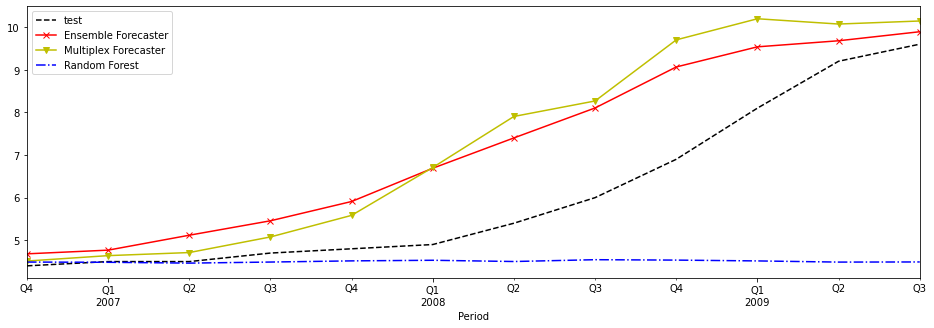

In [515]:
styles = ['k--','rx-','yv-', 'b-.']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col)
plt.legend();plt.show()

In [501]:
multi_grid.best_params_

{'selected_forecaster': 'GradientBoosting'}

In [500]:
multi_grid.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.287071,0.016769,0.006967,{'selected_forecaster': 'LinearRegression'},3.0
1,0.108129,0.305849,0.068155,{'selected_forecaster': 'RandomForest'},2.0
2,0.303801,0.015557,0.006060,{'selected_forecaster': 'SupportVectorRegressor'},4.0
3,0.105496,0.190713,0.007355,{'selected_forecaster': 'GradientBoosting'},1.0


## There is more

In [104]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [108]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(regressors,
                             method='feature-importance')
auto.fit(y=y_train_detrended, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [109]:
auto.weights_

[0.03437287387339173,
 0.043586808956597264,
 0.40219565570278754,
 0.5198446614672234]

In [110]:
auto.regressor_

GradientBoostingRegressor(max_depth=5)

In [111]:
auto.predict(fh=fh, X=exog_test)

NotImplementedError: Generating in-sample predictions is not yet implemented for RecursiveTabularRegressionForecaster.